In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim') # Just because I use Windows
import gensim
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [2]:
%matplotlib notebook

In [3]:
cwd = os.getcwd()
path = os.path.join(cwd,'data')
fn = os.path.join(path, 'voted-kaggle-dataset.csv')
df = pd.read_csv(fn)

In [4]:
print ('len of texts = {:,}'.format(len(df)))
df.loc[10, 'Description']

len of texts = 2,150


'These files contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. The file is a matrix of about 890 thousand observations and 75 variables. A data dictionary is provided in a separate file. k'

In [5]:
df.head(1)

,Title,Subtitle,Owner,Votes,Versions,Tags,Data Type,Size,License,Views,Download,Kernels,Topics,URL,Description
0,Credit Card Fraud Detection,Anonymized credit card transactions labeled as...,Machine Learning Group - ULB,1241,"Version 2,2016-11-05|Version 1,2016-11-03",crime\nfinance,CSV,144 MB,ODbL,"442,136 views","53,128 downloads","1,782 kernels",26 topics,https://www.kaggle.com/mlg-ulb/creditcardfraud,The datasets contains transactions made by cre...


In [26]:
tags = set(df["Tags"].dropna().str.cat(sep = "\n").split("\n"))
print(len(tags))
tags

319


{'+ 2 more...',
 'acoustics',
 'actors',
 'aerospace engineering',
 'africa',
 'agriculture',
 'agronomy',
 'alcohol',
 'american football',
 'animals',
 'animation',
 'antarctica',
 'anthropology',
 'architecture',
 'artificial intelligence',
 'arts and entertainment',
 'asia',
 'association football',
 'astronauts',
 'astronomy',
 'atmospheric sciences',
 'australia',
 'auto racing',
 'automation',
 'automobiles',
 'aviation',
 'banking',
 'baseball',
 'basketball',
 'beginner',
 'biases',
 'bigquery',
 'binary classification',
 'biography',
 'biology',
 'biotechnology',
 'board games',
 'bodies of water',
 'books',
 'botany',
 'brazil',
 'business',
 'card games',
 'categorical data',
 'celebrity',
 'chemical engineering',
 'chemistry',
 'children',
 'china',
 'christianity',
 'cities',
 'civil engineering',
 'classification',
 'climate',
 'clothing',
 'cognitive biases',
 'comics',
 'communication',
 'communities',
 'companies',
 'composers',
 'computer architecture',
 'computer sc

In [7]:
# Droping data with useless description
df["Description"].replace(to_replace ="This dataset does not have a description yet.", value = pd.np.nan, inplace = True)
df.dropna(subset=["Description"], inplace = True)

data = df["Description"].values.tolist()
data = [re.sub('\s+', ' ', sent) for sent in data]

In [8]:
data_tokens = list([gensim.utils.simple_preprocess(str(sentence), deacc=True) for sentence in data])

In [9]:
bigram = models.Phrases(data_tokens, min_count=5, threshold=150)
trigram = models.Phrases(bigram[data_tokens], threshold=150)

bigram_phraser = models.phrases.Phraser(bigram)
trigram_phraser = models.phrases.Phraser(trigram)

In [10]:
stop_words = stopwords.words("english")
# Removing the words that are present in most of the descriptions
stop_words.extend(["acknowledgements", "content", "context", "data", "dataset"])

In [11]:
p_stemmer = PorterStemmer()

In [12]:
data_tokens = [[token for token in text if token not in stop_words] for text in data_tokens]
data_tokens = [[p_stemmer.stem(token) for token in text if token not in stop_words] for text in data_tokens]
data_tokens = [bigram_phraser[text] for text in data_tokens]
data_tokens = [trigram_phraser[text] for text in data_tokens]

In [13]:
print(data_tokens[10])

['file', 'contain', 'complet', 'loan', 'loan', 'issu', 'includ', 'current', 'loan', 'statu', 'current', 'late', 'fulli', 'paid', 'etc', 'latest', 'payment', 'inform', 'file', 'contain', 'loan', 'present', 'contain', 'complet', 'loan', 'loan', 'issu', 'previou', 'complet', 'calendar', 'quarter', 'addit', 'featur', 'includ', 'credit', 'score', 'number', 'financ', 'inquiri', 'address', 'includ', 'zip', 'code', 'state', 'collect', 'among', 'other', 'file', 'matrix', 'thousand', 'observ', 'variabl', 'dictionari', 'provid', 'separ', 'file']


In [14]:
id2word = corpora.Dictionary(data_tokens)
corpus = [id2word.doc2bow(text) for text in data_tokens]
print(corpus[10])

[(26, 1), (31, 3), (33, 1), (34, 2), (47, 1), (57, 1), (60, 2), (66, 1), (83, 1), (87, 1), (113, 1), (165, 1), (197, 3), (250, 1), (294, 1), (315, 1), (348, 4), (413, 1), (430, 1), (442, 1), (451, 1), (473, 1), (502, 3), (604, 1), (655, 1), (902, 1), (978, 1), (979, 1), (980, 1), (981, 1), (982, 1), (983, 1), (984, 1), (985, 6), (986, 1), (987, 1), (988, 1), (989, 1), (990, 1), (991, 1)]


In [15]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 15, 
                                           random_state = 2019,
                                           passes = 40) 

In [16]:
print("Perplexity: ", ldamodel.log_perplexity(corpus))

coherence_model_lda = models.CoherenceModel(model=ldamodel, texts=data_tokens, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score: ", coherence_lda)

Perplexity:  -8.292005483641974
Coherence Score:  0.440829190690013


In [17]:
def compute_coherence_values(id2word, corpus, data, n_topics):
    
    coherence_values = []
    model_list = []
  
    for num_topics in n_topics:
        model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                               id2word = id2word,
                                               num_topics = num_topics, 
                                               random_state = 2019,
                                               passes = 40)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=data, dictionary=id2word, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
n_topics = range(2, 47, 4)
model_list, coherence_values = compute_coherence_values(id2word = id2word, 
                                                        corpus = corpus, 
                                                        data = data_tokens,
                                                        n_topics = n_topics)

<IPython.core.display.Javascript object>


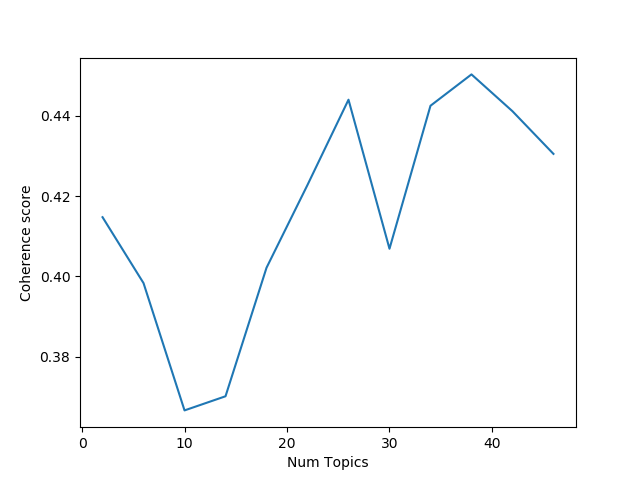

In [19]:
plt.figure()
plt.plot(n_topics, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [21]:
# Basing on a graph above I'd like to run more precise num_topics finder from 23 to 29 and 35 to 41
n_topics = [22, 23, 24, 25, 26, 27, 28, 35, 36, 37, 38, 39, 40, 41] 
model_list, coherence_values = compute_coherence_values(id2word = id2word, 
                                                        corpus = corpus, 
                                                        data = data_tokens, 
                                                        n_topics = n_topics)

In [22]:
for m, cv in zip(n_topics, coherence_values):
    print("Num Topics = {:d} has Coherence Value of {:.4f}".format(m, cv))

Num Topics = 22 has Coherence Value of 0.4228
Num Topics = 23 has Coherence Value of 0.4222
Num Topics = 24 has Coherence Value of 0.3943
Num Topics = 25 has Coherence Value of 0.4188
Num Topics = 26 has Coherence Value of 0.4440
Num Topics = 27 has Coherence Value of 0.4375
Num Topics = 28 has Coherence Value of 0.4307
Num Topics = 35 has Coherence Value of 0.4239
Num Topics = 36 has Coherence Value of 0.4262
Num Topics = 37 has Coherence Value of 0.4404
Num Topics = 38 has Coherence Value of 0.4503
Num Topics = 39 has Coherence Value of 0.4414
Num Topics = 40 has Coherence Value of 0.4585
Num Topics = 41 has Coherence Value of 0.4308


In [43]:
# Splitting the data to 40 topics gives the highest coherence score. 
# However, it creates few topics that are pretty much the same to others. 
# So, I decided to split the data to only 26 topics
ldamodel = model_list[4]
ldamodel.print_topics(num_topics=26,num_words=10)

[(0,
  '0.026*"product" + 0.019*"startup" + 0.016*"day" + 0.015*"lake" + 0.014*"compani" + 0.014*"contain" + 0.013*"segment" + 0.012*"region" + 0.012*"year" + 0.012*"india"'),
 (1,
  '0.063*"educ" + 0.039*"student" + 0.032*"inep" + 0.029*"nation" + 0.021*"higher" + 0.020*"http" + 0.019*"exam" + 0.017*"gov_br" + 0.015*"enad" + 0.015*"enem"'),
 (2,
  '0.031*"dog" + 0.026*"district" + 0.026*"citi" + 0.023*"map" + 0.019*"popul" + 0.018*"center" + 0.017*"state" + 0.016*"centroid" + 0.016*"calcul" + 0.016*"area"'),
 (3,
  '0.021*"file" + 0.017*"use" + 0.012*"question" + 0.012*"user" + 0.011*"id" + 0.009*"txt" + 0.009*"inspir" + 0.009*"joke" + 0.009*"gener" + 0.009*"tweet"'),
 (4,
  '0.039*"model" + 0.038*"train" + 0.034*"imag" + 0.021*"use" + 0.018*"pre" + 0.017*"featur" + 0.014*"contain" + 0.012*"learn" + 0.012*"recognit" + 0.012*"network"'),
 (5,
  '0.031*"model" + 0.025*"train" + 0.020*"use" + 0.017*"accuraci" + 0.015*"time" + 0.014*"squeezenet" + 0.014*"dnn" + 0.013*"pre" + 0.013*"smalle

In [44]:
# Choosing dominant topic for each text
dominant_topics = []
for topic_contrib in list(ldamodel.get_document_topics(corpus)):
    dominant_topics.append(sorted(topic_contrib,key=lambda x:(-x[1],x[0]))[0])
dominant_topics = pd.DataFrame(dominant_topics)
dominant_topics.columns = ["Topic", "Contribution"]

In [45]:
# Naming the topics basing on given text tags
data = pd.concat([dominant_topics, df[["Title", "Tags", "Description"]]], axis = 1)
data[data['Contribution'] == data.groupby(['Topic'])['Contribution'].transform(max)]

,Topic,Contribution,Title,Tags,Description
106,22.0,0.992246,Lower Back Pain Symptoms Dataset,healthcare,"310 Observations, 13 Attributes (12 Numeric Pr..."
163,21.0,0.565795,The Complete Pokemon Dataset,popular culture\nvideo games,Context\nThis dataset contains information on ...
625,19.0,0.954930,Top 980 Starred Open Source Projects on GitHub,internet\nprogramming languages\nprogramming,Context\nGitHub is the leader in hosting open ...
809,16.0,0.988622,English Word Frequency,languages\nlinguistics\ninternet,Context:\nHow frequently a word occurs in a la...
918,4.0,0.993756,"Airports, Train Stations, and Ferry Terminals",transport\naviation\npublic transport\n+ 2 mor...,"Context\nThis is a database of airports, train..."
1218,14.0,0.859498,Elevators in New York City,cities,Context\nThis is a dataset of every registered...
1236,17.0,0.902761,Grammar and Online Product Reviews,databases\ngrammar\nproduct\n+ 2 more...,"About This Data\nThis is a list of over 71,045..."
1346,4.0,0.993756,Eclipse Megamovie,astronomy\nbigquery,This first-of-its-kind citizen science project...
1456,9.0,0.844684,Author Disambiguation,NaN,Name ambiguity has long been viewed as a chall...
1568,12.0,0.992930,Turkish sentences for word2vec training,NaN,In the dataset files there are news from a Tur...
